
Starting Chess Pattern Analysis Pipeline...
Processing data from: C:\Users\Sai Kiran\Downloads\chess_games.csv\chess_games.csv
Processed 6,256,184 games
Creating visualizations and saving results...


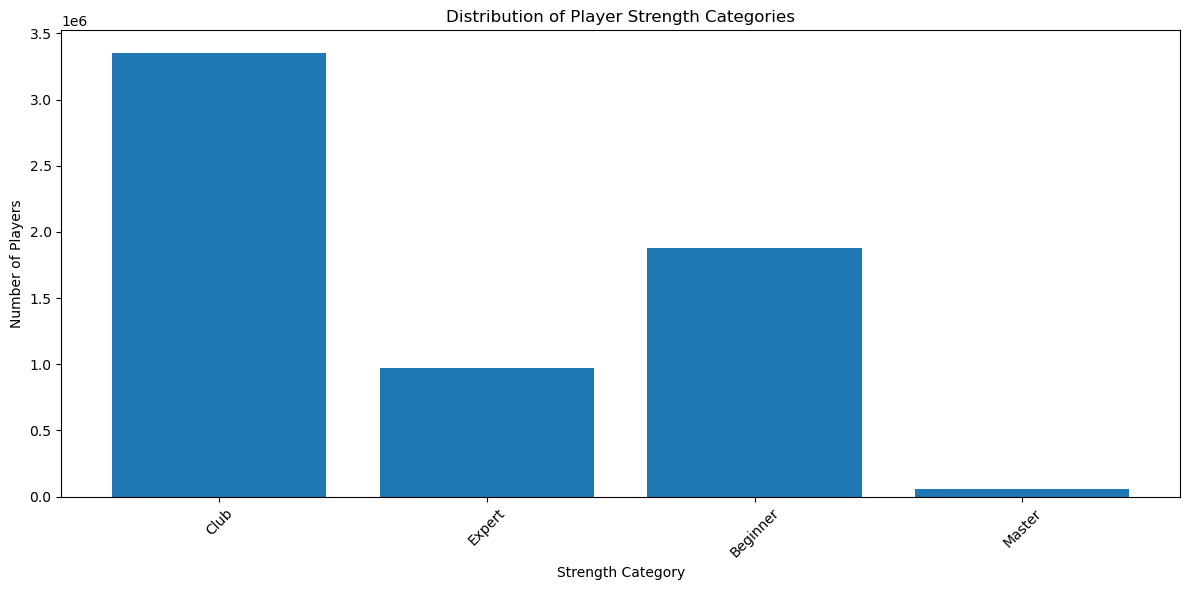

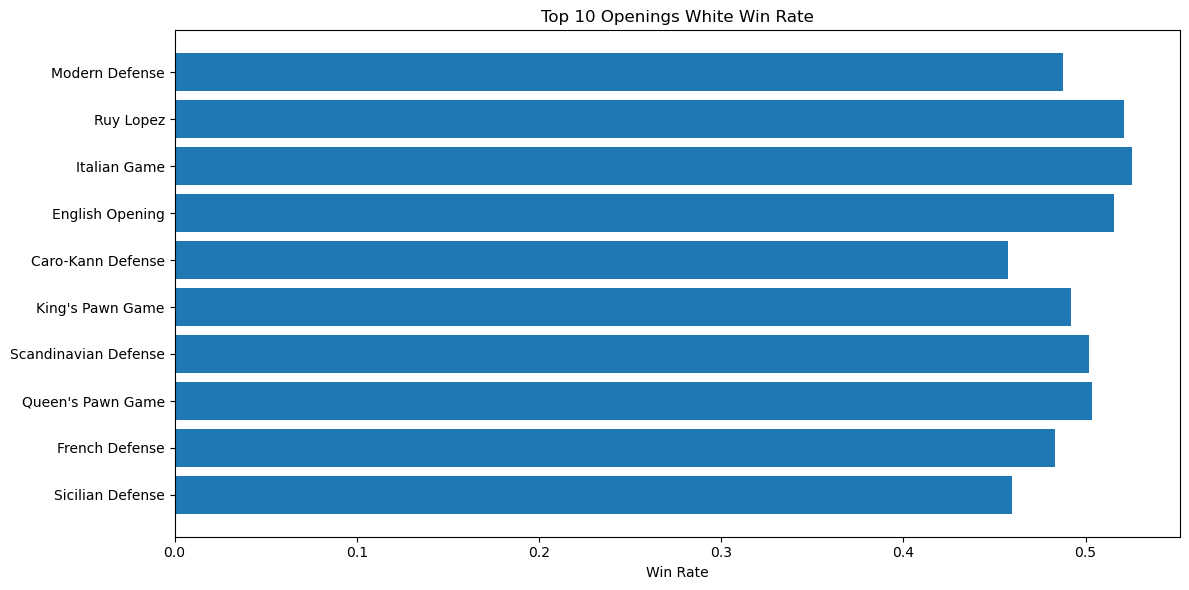

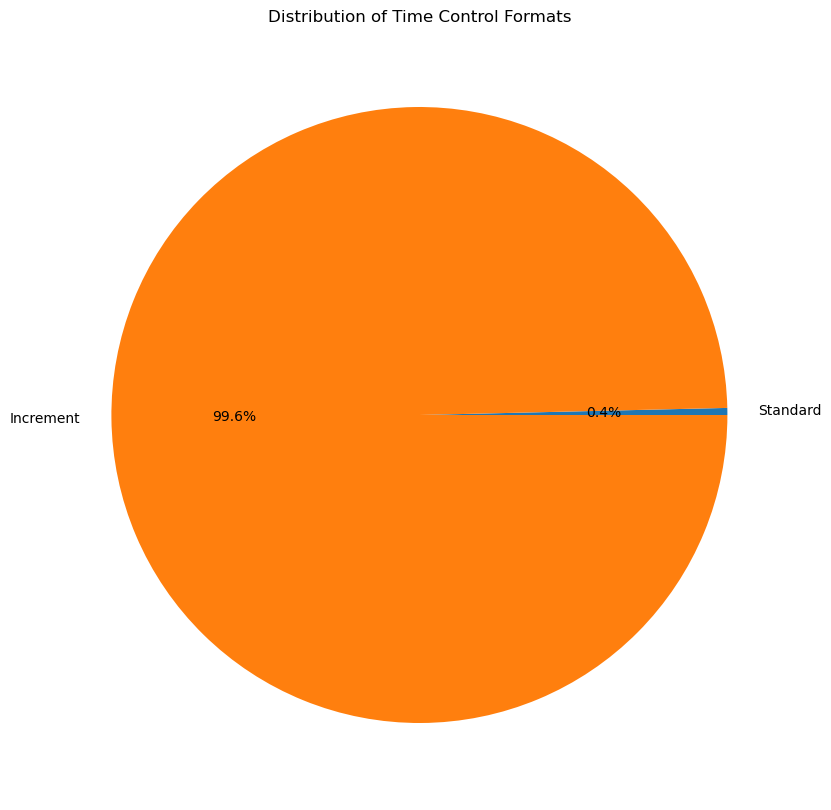

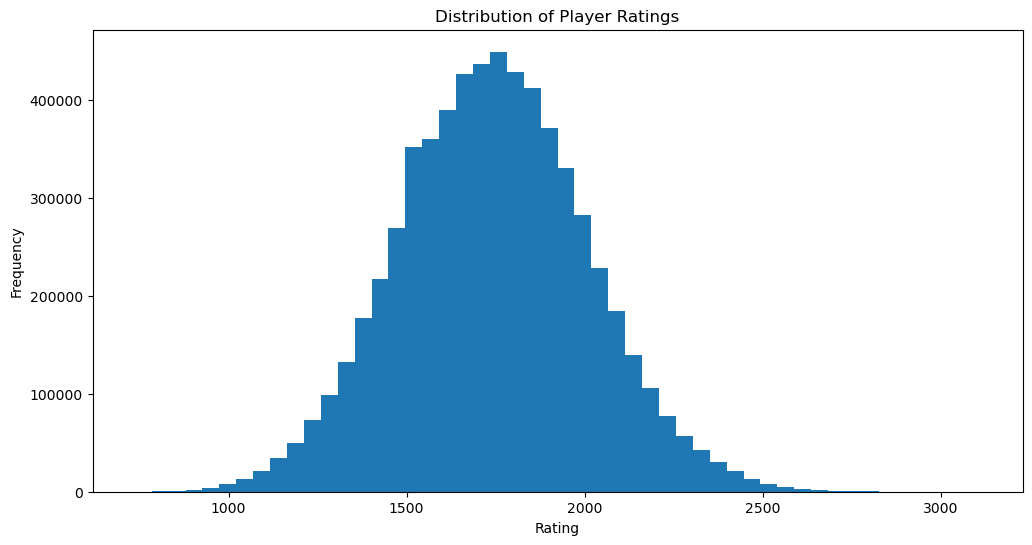

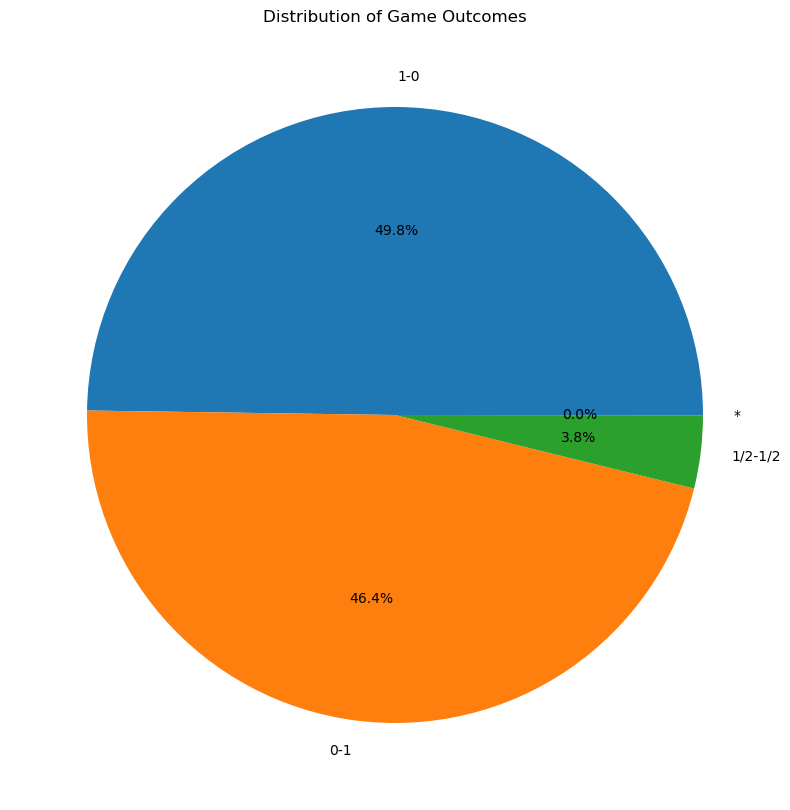


Key Findings:
- Total games analyzed: 6,256,184
- Unique openings: 2,942
- Average player rating: 1742

Analysis completed successfully!


In [3]:
import os
import sys
import traceback
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window


class ChessPatternAnalysis:
    def __init__(self):
        """Initialize Spark session with configurations"""
        self.spark = SparkSession.builder \
            .appName("Chess Pattern Analysis") \
            .config("spark.sql.crossJoin.enabled", "true") \
            .config("spark.sql.adaptive.enabled", "true") \
            .config("spark.sql.shuffle.partitions", "10") \
            .config("spark.driver.memory", "4g") \
            .config("spark.sql.warehouse.dir", "./spark-warehouse") \
            .config("spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version", "2") \
            .master("local[*]") \
            .getOrCreate()

        # Set log level
        self.spark.sparkContext.setLogLevel("ERROR")

    def process_data(self, file_path):
        """Load and process chess games with schema validation"""
        print(f"Processing data from: {file_path}")

        # Define schema with correct data types
        schema = StructType([
            StructField("Event", StringType(), True),
            StructField("White", StringType(), True),
            StructField("Black", StringType(), True),
            StructField("Result", StringType(), True),
            StructField("UTCDate", StringType(), True),
            StructField("UTCTime", StringType(), True),
            StructField("WhiteElo", IntegerType(), True),
            StructField("BlackElo", IntegerType(), True),
            StructField("WhiteRatingDiff", IntegerType(), True),
            StructField("BlackRatingDiff", IntegerType(), True),
            StructField("ECO", StringType(), True),
            StructField("Opening", StringType(), True),
            StructField("TimeControl", StringType(), True),
            StructField("Termination", StringType(), True)
        ])

        # Load and clean data
        self.df = self.spark.read.csv(file_path, header=True, schema=schema)
        
        # Handle missing values
        self.df = self.df.na.fill({
            'WhiteElo': 0,
            'BlackElo': 0,
            'WhiteRatingDiff': 0,
            'BlackRatingDiff': 0
        })

        # Create derived columns
        self.df = self.df \
            .withColumn("StrengthCategory",
                when(col("WhiteElo") >= 2400, "Master")
                .when(col("WhiteElo") >= 2000, "Expert")
                .when(col("WhiteElo") >= 1600, "Club")
                .otherwise("Beginner")) \
            .withColumn("OpeningFamily",
                regexp_extract(col("Opening"), "^[^:]+", 0)) \
            .withColumn("Date", 
                to_date(col("UTCDate"), "yyyy.MM.dd")) \
            .withColumn("TimeFormat",
                when(col("TimeControl").contains("+"), "Increment")
                .when(col("TimeControl").contains("|"), "Tournament")
                .otherwise("Standard"))

        print(f"Processed {self.df.count():,} games")
        return self.df
    def analyze_playing_patterns(self, df):
        """Analyze chess playing patterns"""
        print("Analyzing playing patterns...")
        try:
            # Pattern 1: Opening preferences by rating level
            opening_patterns = df.groupBy("StrengthCategory", "OpeningFamily") \
                .agg(count("*").alias("Count")) \
                .withColumn("Percentage",
                    col("Count") / sum("Count").over(Window.partitionBy("StrengthCategory")) * 100)

            # Pattern 2: Time management analysis
            time_patterns = df.groupBy("TimeFormat", "StrengthCategory") \
                .agg(
                    count("*").alias("GamesCount"),
                    avg("WhiteElo").alias("AverageRating")
                )
            print(opening_patterns,time_patterns)
            return opening_patterns, time_patterns
        except Exception as e:
            print(f"Error in pattern analysis: {str(e)}")
            raise

    def visualize_and_save_results(self, output_path):
        """Create visualizations and save analysis results"""
        print("Creating visualizations and saving results...")
        
        try:
            # Create output directory
            os.makedirs(output_path, exist_ok=True)

            # 1. Player Strength Distribution
            plt.figure(figsize=(12, 6))
            strength_dist = self.df.groupBy("StrengthCategory").count().toPandas()
            plt.bar(strength_dist['StrengthCategory'], strength_dist['count'])
            plt.title('Distribution of Player Strength Categories')
            plt.xlabel('Strength Category')
            plt.ylabel('Number of Players')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(os.path.join(output_path, 'strength_distribution.png'))
            plt.show()
            plt.close()

            # 2. Opening Success Rates
            opening_success = self.df.groupBy("OpeningFamily") \
                .agg(
                    count("*").alias("games_count"),
                    avg(when(col("Result") == "1-0", 1).otherwise(0)).alias("white_win_rate")
                ) \
                .orderBy(desc("games_count")) \
                .limit(10) \
                .toPandas()

            plt.figure(figsize=(12, 6))
            plt.barh(opening_success['OpeningFamily'], opening_success['white_win_rate'])
            plt.title('Top 10 Openings White Win Rate')
            plt.xlabel('Win Rate')
            plt.tight_layout()
            plt.savefig(os.path.join(output_path, 'opening_success.png'))
            plt.show()
            plt.close()

            # 3. Time Control Analysis
            time_pattern = self.df.groupBy("TimeFormat").count().toPandas()
            plt.figure(figsize=(10, 10))
            plt.pie(time_pattern['count'], labels=time_pattern['TimeFormat'], autopct='%1.1f%%')
            plt.title('Distribution of Time Control Formats')
            plt.savefig(os.path.join(output_path, 'time_control_dist.png'))
            plt.show()
            plt.close()

            # 4. Rating Distribution
            plt.figure(figsize=(12, 6))
            plt.hist(self.df.select('WhiteElo').toPandas(), bins=50)
            plt.title('Distribution of Player Ratings')
            plt.xlabel('Rating')
            plt.ylabel('Frequency')
            plt.savefig(os.path.join(output_path, 'rating_distribution.png'))
            plt.show()
            plt.close()

            # 5. Game Outcomes
            outcome_dist = self.df.groupBy("Result").count().toPandas()
            plt.figure(figsize=(10, 10))
            plt.pie(outcome_dist['count'], labels=outcome_dist['Result'], autopct='%1.1f%%')
            plt.title('Distribution of Game Outcomes')
            plt.savefig(os.path.join(output_path, 'game_outcomes.png'))
            plt.show()
            plt.close()

            # Save numerical results
            results = {
                'opening_analysis': opening_success,
                'time_control_analysis': time_pattern,
                'outcome_analysis': outcome_dist
            }

            for name, data in results.items():
                data.to_csv(os.path.join(output_path, f"{name}.csv"), index=False)

            # Print key findings
            print("\nKey Findings:")
            print(f"- Total games analyzed: {self.df.count():,}")
            print(f"- Unique openings: {self.df.select('Opening').distinct().count():,}")
            print(f"- Average player rating: {self.df.select(avg('WhiteElo')).collect()[0][0]:.0f}")

        except Exception as e:
            print(f"Error in visualization: {str(e)}")
            raise

    def run_pipeline(self, input_path, output_path):
        """Execute the complete analysis pipeline"""
        try:
            print("\nStarting Chess Pattern Analysis Pipeline...")
            print("=" * 50)

            # Process and cache data
            self.df = self.process_data(input_path)
            self.df.cache()

            # Create visualizations and save results
            self.visualize_and_save_results(output_path)

            print("\nAnalysis completed successfully!")
            print("=" * 50)

        except Exception as e:
            print("\nPipeline execution failed!")
            print(f"Error: {str(e)}")
            traceback.print_exc()
            raise

def main():
    try:
        # Initialize pipeline
        pipeline = ChessPatternAnalysis()

        # Define paths
        input_path = r"C:\Users\Sai Kiran\Downloads\chess_games.csv\chess_games.csv"
        output_path = "chess_analysis_results"

        # Execute pipeline
        pipeline.run_pipeline(input_path, output_path)

    except Exception as e:
        print("\nPipeline execution failed!")
        traceback.print_exc()  
        raise



if __name__ == "__main__":
    main()